In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from Forcasting import graph, conversionSingle, rmsemape
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Load your data
import pandas as pd
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(data_url, parse_dates=['Month'], index_col='Month')
data = data.rename(columns={'Passengers': 'Passenger_Count'})


In [3]:
data.head()

,Passenger_Count
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Passenger_Count']])
print("Len:", data_scaled.shape)

Len: (144, 1)


In [5]:
# Split data into train and test sets
training_size = round(len(data_scaled) * 0.80)
print("Training Size:", training_size)


Training Size: 115


In [6]:
X_train = data_scaled[:training_size]
X_test = data_scaled[training_size:]
print("X_train length:", X_train.shape)
print("X_test length:", X_test.shape)

y_train = data_scaled[:training_size]
y_test = data_scaled[training_size:]
print("y_train length:", y_train.shape)
print("y_test length:", y_test.shape)

X_train length: (115, 1)
X_test length: (29, 1)
y_train length: (115, 1)
y_test length: (29, 1)


In [10]:
# Fit SARIMA model
p = 1  # AR term
d = 1  # Differencing term
q = 1  # MA term
P = 1  # Seasonal AR term
D = 1  # Seasonal differencing term
Q = 1  # Seasonal MA term
s = 12  # Seasonal period (monthly data -> 12)

model = SARIMAX(X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

In [11]:
# Predict on test set
y_pred = model_fit.predict(start=len(X_train), end=len(data_scaled)-1, typ='levels')
print("RMSE-Testset:", mean_squared_error(y_test, y_pred, squared=False))
print("MAPE-Testset:", mean_absolute_percentage_error(y_test, y_pred))

RMSE-Testset: 0.057973909468364976
MAPE-Testset: 0.06568283085532838


In [12]:
# Plot actual vs predicted
y_test_df = pd.DataFrame(y_test, columns=['Passenger_Count'])
y_pred_df = pd.DataFrame(y_pred, columns=['Passenger_Count'])

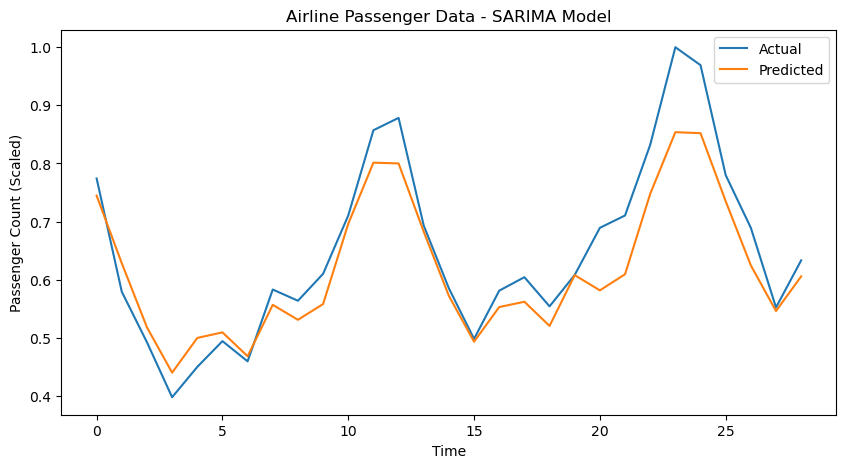

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_df, label="Actual")
plt.plot(y_pred_df, label="Predicted")
plt.title("Airline Passenger Data - SARIMA Model")
plt.xlabel("Time")
plt.ylabel("Passenger Count (Scaled)")
plt.legend()
plt.show()

In [14]:
# Inverse transform predictions to original scale
aTestNormTable = pd.DataFrame(y_test, columns=['Passenger_Count'])
actual_passenger_count = scaler.inverse_transform(aTestNormTable)
actual_passenger_count_df = conversionSingle(actual_passenger_count, ['Passenger_Count'])
print("Actual Passenger Count:\n", actual_passenger_count_df)

Actual Passenger Count:
     Passenger_Count
0             505.0
1             404.0
2             359.0
3             310.0
4             337.0
5             360.0
6             342.0
7             406.0
8             396.0
9             420.0
10            472.0
11            548.0
12            559.0
13            463.0
14            407.0
15            362.0
16            405.0
17            417.0
18            391.0
19            419.0
20            461.0
21            472.0
22            535.0
23            622.0
24            606.0
25            508.0
26            461.0
27            390.0
28            432.0


In [15]:
pTestNormTable = pd.DataFrame(y_pred, columns=['Passenger_Count'])
predicted_passenger_count = scaler.inverse_transform(pTestNormTable)
predicted_passenger_count_df = conversionSingle(predicted_passenger_count, ['Passenger_Count'])
print("Predicted Passenger Count:\n", predicted_passenger_count_df)

Predicted Passenger Count:
     Passenger_Count
0        489.691104
1        429.433222
2        372.325183
3        331.896816
4        362.842150
5        367.822558
6        346.535552
7        392.358961
8        379.011744
9        393.044908
10       464.605155
11       519.100869
12       518.402688
13       457.553115
14       400.306192
15       359.490917
16       390.384533
17       395.098993
18       373.559403
19       418.824553
20       405.260295
21       419.605601
22       491.300299
23       546.273656
24       545.380938
25       484.719255
26       427.515480
27       386.822786
28       417.732451


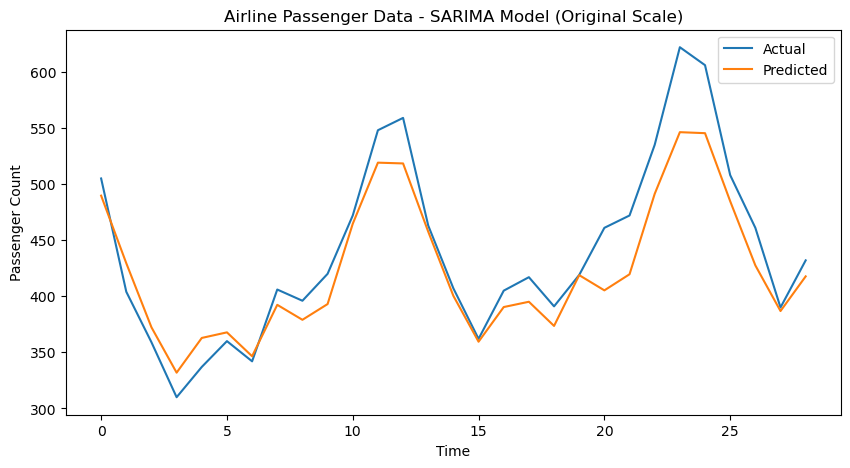

In [16]:
# Plot actual vs predicted with original scale
plt.figure(figsize=(10, 5))
plt.plot(actual_passenger_count_df, label="Actual")
plt.plot(predicted_passenger_count_df, label="Predicted")
plt.title("Airline Passenger Data - SARIMA Model (Original Scale)")
plt.xlabel("Time")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()

In [17]:
# Evaluate performance on original scale
rmsemape(actual_passenger_count_df, predicted_passenger_count_df)

RMSE-Testset: 30.030485104613067
MAPE-Testset: 0.050282230446986535


In [18]:
# Forecast future values
forecast_steps = 12  # Forecasting for 1 year
forecast = model_fit.predict(start=len(data_scaled), end=len(data_scaled) + forecast_steps - 1, typ='levels')

In [19]:
# Inverse transform forecast to original scale
fTestNormTable = pd.DataFrame(forecast, columns=["Forecast"])
forecast_passenger_count = scaler.inverse_transform(fTestNormTable)
forecast_passenger_count_df = conversionSingle(forecast_passenger_count, ["Forecast"])
forecast_passenger_count_df.to_csv("AirlinePassengerForecast_SARIMA.csv", index=False)

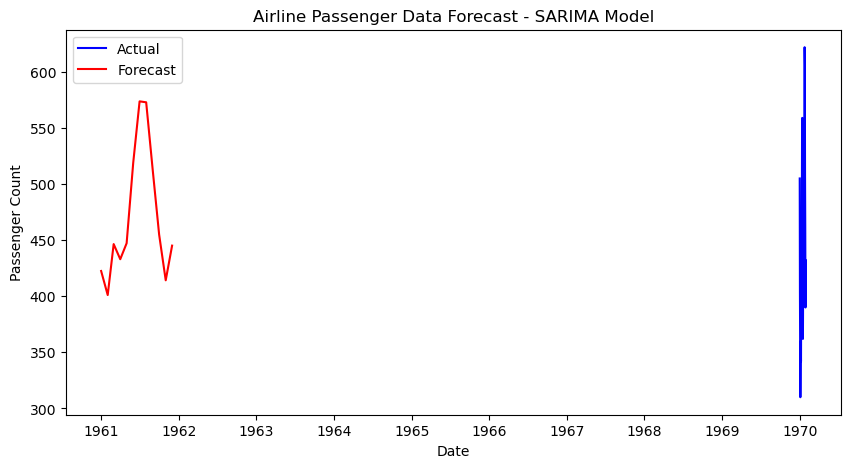

In [20]:
# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(actual_passenger_count_df, color='blue', label="Actual")
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps, freq='M'), forecast_passenger_count_df, color='red', label="Forecast")
plt.title("Airline Passenger Data Forecast - SARIMA Model")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()